In [300]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re

%matplotlib inline

In [301]:
df = pd.read_json("chili.json")

In [302]:
df.head()

,calories,carbs,description,fat,ingredients,protein,rating,reviews,title
0,371kcal,31.6g,"&#34;If you want a good, basic chili recipe, t...",17.5g,"[2 pounds ground beef, 2 onions, chopped, 4 cl...",24.5g,4.33,3,My Simple Chili Recipe - Allrecipes.com
1,281kcal,30.9g,"&#34;This is my version of Chicken Chili, it w...",3.6g,"[2 pounds skinless, boneless chicken breast me...",34.8g,4.08,26,Momma OB's Chicken Chili Recipe - Allrecipes.com
10,403kcal,50.5g,&#34;Prepared pepper and onion relish adds a z...,11.6g,[1 (8.75 ounce) jar Dickinson's&#174; Sweet 'n...,24.6g,0.00,0,Zesty White Chicken Chili Recipe - Allrecipes.com
100,480kcal,24.9g,"&#34;This is the tastiest, easiest chili recip...",31.1g,"[2 pounds ground beef, 1/2 onion, chopped, 1 t...",26.7g,4.76,2075,Debdoozie's Blue Ribbon Chili Recipe - Allreci...
101,388kcal,28.8g,&#34;This is a wonderful dish for cold winter ...,20.6g,"[2 tablespoons vegetable oil, 1 pound ground b...",21g,4.44,14,Shay's Irish Chili Recipe - Allrecipes.com


## Cleaning!

In [303]:
def clean_title(x):
    #remove the - Allrecipes.com bit
     #also, remove the words chili recipe.   Yes, she knows it's a multipass
    return  x.split(' - ')[0].lower().replace("chili recipe", "")
   
df.title = df.title.map(clean_title)
    


In [304]:
def clean_macro(x):
    return x.replace("g","").replace("kcal","")

#clean these guys & recast as floats
df.calories = df.calories.map(clean_macro).astype(float)
df.fat = df.fat.map(clean_macro).astype(float)
df.carbs = df.carbs.map(clean_macro).astype(float)
df.protein = df.protein.map(clean_macro).astype(float)



In [305]:
def clean_description(x):
    return x.replace("&#34;","")

df.description = df.description.map(clean_description)

In [306]:
#going to rearrange the columns in prep for what comes next
df.columns

Index([u'calories', u'carbs', u'description', u'fat', u'ingredients',
       u'protein', u'rating', u'reviews', u'title'],
      dtype='object')

In [307]:
col = ['rating', 'reviews', 'title', 'protein', 'carbs','fat','calories','description', 'ingredients']
df = df[col]

In [308]:
#removing 0 rated, 0 reviewed data.  They might be great, but they aren't informative.
df=df[df.rating>0]
df = df[df.reviews>0]

### Examning Scores

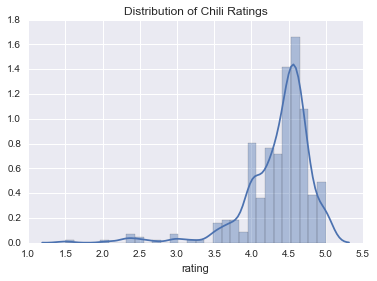

In [309]:
plt.title("Distribution of Chili Ratings")
sns.distplot(df.rating)

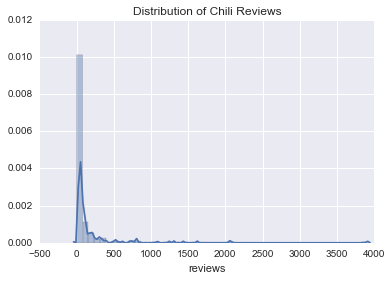

In [328]:
plt.title("Distribution of Chili Reviews")
sns.distplot(df.reviews)

In [330]:
df.reviews.describe()

count     382.000000
mean      101.740838
std       309.701471
min         1.000000
25%         6.000000
50%        18.000000
75%        65.000000
max      3901.000000
Name: reviews, dtype: float64

I'm going to attempt to normalize these ratings by their popularity using a technique called 'bayesian average rating'

Roughly

Ra = W R + (1-W) R0

where
Ra = Averaged 'bayesian' Rating
R = Indvidual Raiting :  Average Rating for this item
R0 = a priori raiting:  I'll use the global average
W = weight factor

Possible Ws includ W = n/Nmax where n is reviews of item, and Nmax is total reviews
or W = max(alpha * n/Nmax, 1) where alpha is some number (.5..1)

I should markdown this, but I'm a lazy bum.  Also, this is stolen from here:
http://math.stackexchange.com/questions/41459/how-can-i-calculate-most-popular-more-accurately/41513#41513


IMDB uses a particular instance of this formula, 

weighted rank (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

 where:
  R = average for the movie (mean) = (Rating)
  v = number of votes for the movie = (votes)
  m = minimum votes required to be listed in the Top 250 (currently 1250)
  C = the mean vote across the whole report (currently 6.8)


In [337]:
m=df.reviews.mean()
R = (df.reviews / (df.reviews + m ))*df.rating + (m / (df.reviews + m ) ) * df.rating.mean()

In [340]:
df.rating.describe()

count    382.000000
mean       4.362644
std        0.470354
min        1.500000
25%        4.202500
50%        4.495000
75%        4.637500
max        5.000000
Name: rating, dtype: float64

In [339]:
R.describe()

count    382.000000
mean       4.395908
std        0.087378
min        4.145958
25%        4.351319
50%        4.374869
75%        4.424188
max        4.788883
dtype: float64

In [341]:
#i'm fairly satisified with this weighted rank for now.  note that m can be fiddled with to monkey with the variability 


m=df.reviews.mean()
df['WeightedRank'] = (df.reviews / (df.reviews + m ))*df.rating + (m / (df.reviews + m ) ) * df.rating.mean()

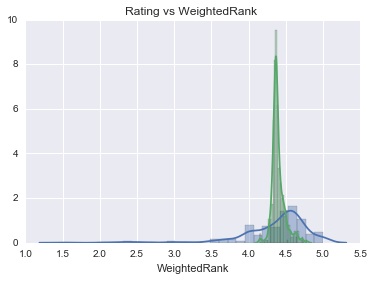

In [342]:
plt.title("Rating vs WeightedRank ")
sns.distplot(df.rating)
sns.distplot(df.WeightedRank)
plt.show()

### Back to the mission

Ok, so we have to make the world's best data driven chili.   My current thinking is that we need to identify the things that go in this hypothetical chilli, and then figure out amounts.  But before we get there...we're going to need to know what kind of chili.  So.  The way I see this problem going at this point is

1.  Beef, Poultry, or Vegetarian  I think this is an important question because the ingredients don't overlap, especially between Poultry (white chili) and beef.  (So, split dataframe into three?)

2.  Ok, so then we can figure out the most common (or recommended) ingredients in a chili corresponding to the variety.  (recommender or something, I dunno yet)

3.  I think 1 and 2 give us the most common items in the most popular chilis.  But, I suspect *winning* requires more than good.  What does it take to go from good to great?  Outliers I would suppose?

### Ugh, Ingredients

In [343]:
import itertools
#big flat list of all ingredients
all_ingredients = list(itertools.chain.from_iterable(df.ingredients))
all_ingredients = [x.encode('utf-8').lower() for x in all_ingredients]

In [344]:
#cleaning measurements off ingredients
all_ingredients = [ re.sub(r"[^A-Za-z ]+", '', x) for x in all_ingredients]

In [345]:
def remove_unit(x):
    units = ['teaspoons','teaspoon', 'tablespoons', 'tablespoon','cups','cup','ounces', 'ounce','pounds','pound',
             'canned', 'cans ','can ','medium', 'large', 'jar', 'ground', 'fresh', 'dried', 'slices', 'chopped',
            'peeled', ' and', 'halved', 'diced', 'optional', 'drained', 'mashed', 'seeded', 'stemmed',
             'retain', 'half', ' the', 'liquid', 'stalks', ' into', ' in', 'puree', 'cut', ' into', 'inch', 'dice',
            'divided', 'halves', 'crumbled', ' by', ' hand', 'finely', 'removed', 'toch', 'cubes', 'shredded', 
             'rinsed', 'roasted', 'torn', 'bitesize', 'pieces', 'seasoned', 'package', 'to ', 'taste', 'cubed',
             'minced', ' or', 'more', ' if', 'needed', 'as ', 'bunch', 'whole ', 'quart', 'lengthwise', 
             'sliced', 'thinly', 'with', 'dash', 'dry', 'del monte', 'such','fluid','bottle', 'stems','seeds',
            'thawed', 'other', 'patted', 'crosswise', 'coarsely', 'thirds']
    big_regex = re.compile('|'.join(map(re.escape, units)))
    cleaned_strings =  big_regex.sub("", x).strip()
    return cleaned_strings.replace("  "," ")

In [346]:
def clean_list(x_list):
    no_measures = [ re.sub(r"[^A-Za-z ]+", '', x) for x in x_list]
    return [remove_unit(x) for x in no_measures]



In [347]:
#not using this anymore...but cool code
# #this is a set of all 'cleaned' ingredients
# cleaned_ingredients = list(set(map(remove_unit, all_ingredients)))
# #create a copy of the data, create indicators for each ingredient... KABOOM!
# df2 = df.copy()
# for ingredient in cleaned_ingredients:
#     df2[ingredient]=0

In [348]:
#clean ingredients in the dataframe
df.ingredients = df.ingredients.map(clean_list)

In [349]:
#this will join all the strings in the list of ingredients with | then get dummies them.  Thank dog this exists
#because it would be a m* f* pterodactyl to implement. 
dummies = df.ingredients.str.join("|").str.get_dummies(sep = "|")

In [350]:
dummies.shape

(382, 948)

In [369]:
df2 = df.drop(['ingredients'], axis=1)

In [370]:
df2 = pd.concat([df2, dummies], axis=1)

In [371]:
df2.shape

(382, 957)

In [372]:
df2.to_json("chili_exploded.json")

In [399]:
df_chicken = df2[(df2.description.str.contains("chicken")) | (df2.title.str.contains("chicken"))]
df_turkey = df2[(df2.description.str.contains("turkey")) | (df2.title.str.contains("turkey"))]
df_veg = df2[(df2.description.str.contains("vegetarian")) | (df2.title.str.contains("vegetarian"))]
df_fish = df2[(df2.description.str.contains("fish")) | (df2.title.str.contains("fish"))] #weird

In [400]:
df_beef= df2[(-df2.description.str.contains("chicken")) & (-df2.title.str.contains("chicken"))]
df_beef= df_beef[(-df_beef.description.str.contains("turkey")) & (-df_beef.title.str.contains("turkey"))]
df_beef= df_beef[(-df_beef.description.str.contains("vegetarian")) & (-df_beef.title.str.contains("vegetarian"))]
df_beef= df_beef[(-df_beef.description.str.contains("fish")) & (-df_beef.title.str.contains("fish"))]


In [401]:
df_beef.WeightedRank.describe()

count    260.000000
mean       4.391063
std        0.087476
min        4.145958
25%        4.348716
50%        4.372072
75%        4.413504
max        4.788883
Name: WeightedRank, dtype: float64

In [402]:
df_veg.WeightedRank.describe()

count    22.000000
mean      4.409107
std       0.100124
min       4.267696
25%       4.338938
50%       4.378630
75%       4.472743
max       4.661888
Name: WeightedRank, dtype: float64

In [403]:
df_chicken.WeightedRank.describe()

count    52.000000
mean      4.406657
std       0.074486
min       4.297329
25%       4.354939
50%       4.390594
75%       4.432853
max       4.653430
Name: WeightedRank, dtype: float64

In [404]:
df_turkey.WeightedRank.describe()

count    52.000000
mean      4.412272
std       0.097411
min       4.274612
25%       4.359114
50%       4.376407
75%       4.440619
max       4.716148
Name: WeightedRank, dtype: float64

In [405]:
print df_beef.rating.mean()
print df_beef.rating.std()

4.32365384615
0.521578495357


In [406]:
print df_chicken.rating.mean()
print df_chicken.rating.std()

4.45538461538
0.27309024249


In [407]:
print df_turkey.rating.mean()
print df_turkey.rating.std()

4.49288461538
0.350911063748


In [408]:
print df_veg.rating.mean()
print df_veg.rating.std()

4.34409090909
0.327365517149


In [409]:
df_beef.WeightedRank.max()

4.788883375230502

In [410]:
df_chicken.WeightedRank.max()

4.6534303476718319

In [411]:
df_turkey.WeightedRank.max()

4.7161482187385149

In [412]:
df_veg.WeightedRank.max()

4.6618879650840945

In [413]:
df_beef[df_beef.WeightedRank > 4.7]

,rating,reviews,title,protein,carbs,fat,calories,description,WeightedRank,Alfredo sauce,...,yellow onion ch,yellow onions,yellow pepper,yellow sport pepper sauce TexPetess,yellow squash,yellow wax peppers,yellow white corn,yellow wholekernel corn frozen,ziti pasta,zucchini
100,4.76,2075,debdoozie's blue ribbon,26.7,24.9,31.1,480,"This is the tastiest, easiest chili recipe you...",4.741428,0,...,0,0,0,0,0,0,0,0,0,0
148,4.80,3901,boilermaker tailgate,30.8,55.3,30.1,600,This is the chili recipe the gang eats at Purd...,4.788883,0,...,0,0,0,0,0,0,0,0,0,0
267,4.73,1438,flatlander,21.4,22.6,19.9,347,"Easy to make, great anytime, and always a favo...",4.705726,0,...,0,0,0,0,0,0,0,0,0,0


In [417]:
df_beef.ix[:,0:9]

,rating,reviews,title,protein,carbs,fat,calories,description,WeightedRank
0,4.33,3,my simple,24.5,31.6,17.5,371,"If you want a good, basic chili recipe, this i...",4.361709
100,4.76,2075,debdoozie's blue ribbon,26.7,24.9,31.1,480,"This is the tastiest, easiest chili recipe you...",4.741428
101,4.44,14,shay's irish,21.0,28.8,20.6,388,This is a wonderful dish for cold winter days ...,4.372001
102,4.90,6,sausage-corn,11.8,31.3,14.4,289,"For a quick week-night meal, this chili--with ...",4.392569
105,4.59,13,polish,21.7,17.3,31.1,435,I received this recipe from my sister-in-law's...,4.388403
107,4.00,2,old mama's fashioned,23.7,46.7,10.2,362,This spooky chili is great for Halloween dinne...,4.355653
108,5.00,1,sausage & sweet potato,18.6,33.3,16.7,358,"Chili gets a makeover with Italian sausage, Cr...",4.368848
11,4.63,13,presidential debate,17.1,24.4,7.2,240,A basic but tasty chili recipe that you can ke...,4.392935
110,4.00,2,southwestern-style lime,20.9,28.4,9.3,265,I came up with this recipe the first week of O...,4.355653
111,4.33,8,chef john's italian sausage,32.3,31.4,37.7,599,I've added pork to ground beef in chili before...,4.360264


In [418]:
df_chicken.ix[:,0:9]

,rating,reviews,title,protein,carbs,fat,calories,description,WeightedRank
1,4.08,26,momma ob's chicken,34.8,30.9,3.6,281,"This is my version of Chicken Chili, it was ki...",4.305115
132,4.63,33,spicy white chili with chicken recipe,27.1,55.0,7.3,386,Delicious white chicken chili! Make on stove t...,4.428123
137,4.29,13,rotisserie chicken chili with hominy and chile...,32.1,20.2,25.0,436,"Spices permeate the entire dish - cumin, orega...",4.354414
138,4.00,4,buffalo chicken chili by pam® recipe,18.9,6.5,8.4,182,Enjoy the flavor of Buffalo chicken recreated ...,4.348926
15,4.00,3,award winning chicken,22.3,36.7,24.0,439,I make this recipe for football Sunday afterno...,4.352257
153,4.27,58,slow cooker sweet chicken,25.3,30.5,4.8,262,"Chicken simmers with beans, onions and brown s...",4.329006
157,4.53,525,chicken and corn,20.4,22.6,2.3,188,This is an easy slow cooker meal - use your im...,4.502833
158,4.56,60,easy white chicken,34.7,53.0,11.6,466,This is a recipe given to me by a good friend ...,4.435856
160,4.54,89,crock-pot® chicken,28.8,62.9,2.9,386,"Made a chicken chili recipe, and it was bland....",4.445399
162,4.33,53,slow cooker chicken and sausage,24.7,30.3,11.2,315,"After browsing through many, many chili recipe...",4.351463


In [421]:
cor_cols = ["rating", "reviews", "WeightedRank", "calories", "protein", "carbs", "fat"]
df_cor = df2[cor_cols]

In [422]:
df_cor.shape

(382, 7)

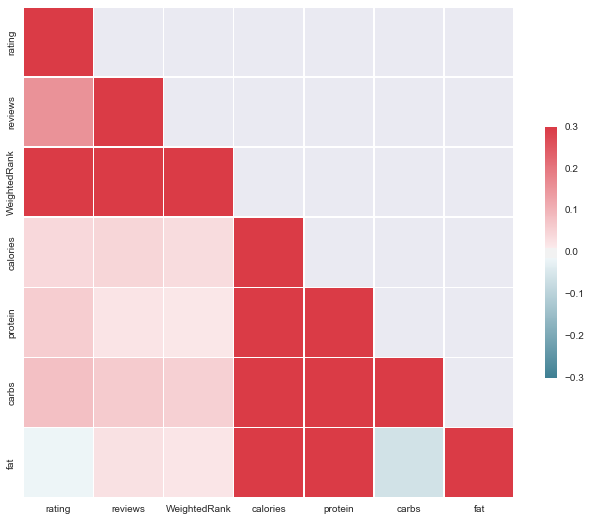

In [459]:
corr = df_cor.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask,1)] = True


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)



In [460]:
#so, this was surprising to me, I expected a strong correlation between fat, calories and rating.

#There was some, but not much.